In [1]:
import random

import numpy as np
import seaborn as sns

from scipy.stats import beta, bernoulli
from matplotlib import pyplot as plt

## Байесовские A/B-тесты

Подход к A/B-тестированию, который мы рассмотрели, называется частотным. При таком подходе до окончания периода эксперимента нельзя перераспределять пользователей в группах, что на практике может привести к потерям.

Существует альтернативный подход, позволяющий менять соотношение объёмов выборок. Рассмотри связанную с ним задачу.

# Многорукие бандиты

Многорукий бандит (MAB, multi-armed bandit) — набор распределений "вознаграждений" $B = \left\{ R_1, ..., R_k \right\}$ (можно представить как ряд из нескольких одноруких бандитов). $\mu_1, ..., \mu_k$ — средние распределений. Игрок дёргает ручки автоматов, задача — максимизировать выигрыш при ограниченном количестве раундов $N$.

После раунда $t$ мы наблюдали результаты $(x_1, ..., x_t)$ раундов. Пусть в момент $t$ мы выбрали автомат $R_{a_t}$.

Будем симулировать проведение эксперимента с замером CTR в реальном времени. В этом случае аознаграждение может быть равно 0 или 1.

In [2]:
click_bandit = [
    lambda: bernoulli.rvs(0.4),
    lambda: bernoulli.rvs(0.5),
    lambda: bernoulli.rvs(0.6)
    ]
n = 3000
k = len(click_bandit)

Метрики:
* Optimal impressions rate — количество игр, сыгранных оптимальным автоматом на данный момент

In [3]:
def get_optimal_impressions_rate(ctrs, wins):
    return sum([np.argmax([ctrs[i][t] for i in range(len(ctrs))]) == wins[t] for t in range(n)])

* Regret — разность коэффициента конверсии в случае, если бы мы всегда выбирали текущий оптимальный автомат, и практически полученного

In [4]:
def plot_regrets(ctrs, wins):
    regrets = []
    regret = 0
    for t in range(n):
        max_index = np.argmax([ctrs[i][t] for i in range(len(ctrs))])
        win_index = wins[t]
        regret += ctrs[max_index][t] - ctrs[win_index][t]
        regrets.append(regret)
    plt.plot(list(range(n)), regrets, label='regrets')
    plt.legend()
    plt.show()

### Эпсилон-жадный алгоритм
1. Проводится некоторое начальное количество наблюдений

In [5]:
n_init = 100
impressions = np.zeros(k)
clicks = np.zeros(k)

for index in range(n_init):
    bandit_index = random.choice([0, 1, 2])
    impressions[bandit_index] += 1
    clicks[bandit_index] += click_bandit[bandit_index]()

for index in range(k):
    print(index, "clicks:\t", clicks[index])
    print(index, "impressions:\t", impressions[index])
    print(index, "CTR:\t\t", clicks[index] / impressions[index])

0 clicks:	 15.0
0 impressions:	 44.0
0 CTR:		 0.3409090909090909
1 clicks:	 13.0
1 impressions:	 27.0
1 CTR:		 0.48148148148148145
2 clicks:	 24.0
2 impressions:	 29.0
2 CTR:		 0.8275862068965517


2. Выбирается бандит с наилучшими показателями за период

In [6]:
ctrs = clicks / impressions
win_index = np.argmax(ctrs)
win_index

2

3. Далее для заранее определённого $\epsilon$ в $\epsilon \%$ случаев выбираем этого бандита, в оставшихся $(100 - \epsilon) \%$ — случайный из всех остальных.

In [7]:
e = 0.8
weights = [(1 - e) / (k - 1)] * k
weights[win_index] = e
weights

[0.09999999999999998, 0.09999999999999998, 0.8]

In [8]:
index_list = [] 
impressions = np.zeros(k)
clicks = np.zeros(k)
ctrs = {i: [] for i in range(k)}
wins = []

for t in range(n): 
    epsilon_index = random.choices(list(range(k)), weights)[0]
    wins.append(epsilon_index)

    impressions[epsilon_index] += 1
    did_click = click_bandit[epsilon_index]()
    clicks[epsilon_index] += did_click
    step_ctrs = [(0 if impressions[b] == 0 else clicks[b] / impressions[b]) for b in range(k)]
    for b in range(k):
        ctrs[b].append(step_ctrs[b])
    

for index in range(k):
    print(index, "interactions:\t", impressions[index])
    print(index, "interactions proportion:", impressions[index] / n)
    print(index, "CTR:\t", clicks[index] / impressions[index], "\n")
print("\nTotal reward for", n, "impressions:", sum(clicks))
print("Optimal impressions rate:", get_optimal_impressions_rate(ctrs, wins))

0 interactions:	 271.0
0 interactions proportion: 0.09033333333333333
0 CTR:	 0.3800738007380074 

1 interactions:	 294.0
1 interactions proportion: 0.098
1 CTR:	 0.5204081632653061 

2 interactions:	 2435.0
2 interactions proportion: 0.8116666666666666
2 CTR:	 0.6151950718685831 


Total reward for 3000 impressions: 1754.0
Optimal impressions rate: 2128


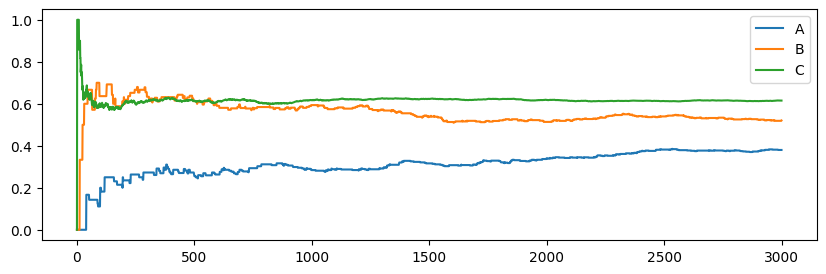

In [9]:
plt.rcParams["figure.figsize"] = (10,3)
plt.plot(list(range(n)), ctrs[0], label='A')
plt.plot(list(range(n)), ctrs[1], label='B')
plt.plot(list(range(n)), ctrs[2], label='C')
plt.legend()
plt.show()

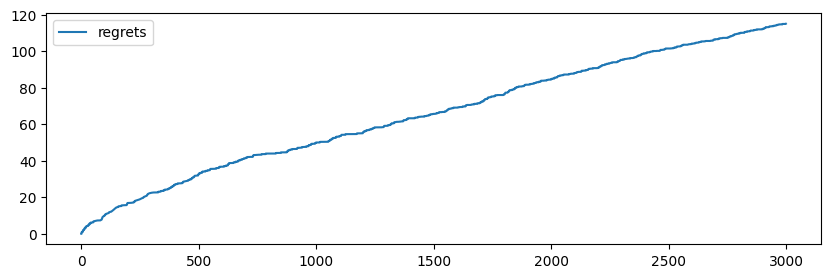

In [10]:
plot_regrets(ctrs, wins)

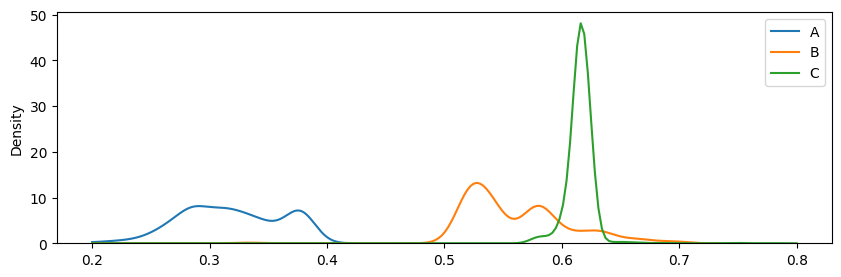

In [11]:
sns.kdeplot(ctrs[0], clip=(0.2, 0.8), label='A') 
sns.kdeplot(ctrs[1], clip=(0.2, 0.8), label='B')
sns.kdeplot(ctrs[2], clip=(0.2, 0.8), label='C')
plt.legend()

Проблема алгоритма в том, что за начальный период можно выбрать не того бандита, у которого фактически окажется самый высоки CTR.

### Верхняя доверительная граница (upper confidence bound, UCB)

Подход использует неравенство Хёфдинга — оценку сверху вероятности отклонения от математического ожидания. Результат:
$$i_{t + 1}=argmax(\frac{clicks_i}{impressions_i} + \sqrt{\frac{2 \log t}{impressions_i}})$$

In [12]:
def get_ucb_for(index, t):
    if (impressions[index] == 0):
        return 1
    return (clicks[index]/impressions[index] + np.sqrt(2*np.log(t+1)/impressions[index]))

In [13]:
impressions = np.zeros(k)
clicks = np.zeros(k)
ctrs = {i: [] for i in range(k)}
wins = []

win_index = random.choice(list(range(k)))

for t in range(n):
    wins.append(win_index)
    impressions[win_index] += 1
    did_click = click_bandit[win_index]()
    clicks[win_index] += did_click
    step_ctrs = [(0 if impressions[b] == 0 else clicks[b] / impressions[b]) for b in range(k)]
    for b in range(k):
        ctrs[b].append(step_ctrs[b])

    bounds = [get_ucb_for(i, t) for i in range(k)]
    win_index = np.argmax(bounds)

for index in range(k):
    print(index, "interactions:\t", impressions[index])
    print(index, "interactions proportion:", impressions[index] / n)
    print(index, "CTR:\t", clicks[index] / impressions[index], "\n")
print("\nTotal reward for", n, "impressions:", sum(clicks))
print("Optimal impressions rate:", get_optimal_impressions_rate(ctrs, wins))

0 interactions:	 190.0
0 interactions proportion: 0.06333333333333334
0 CTR:	 0.3736842105263158 

1 interactions:	 371.0
1 interactions proportion: 0.12366666666666666
1 CTR:	 0.4582210242587601 

2 interactions:	 2439.0
2 interactions proportion: 0.813
2 CTR:	 0.5863058630586306 


Total reward for 3000 impressions: 1671.0
Optimal impressions rate: 2484


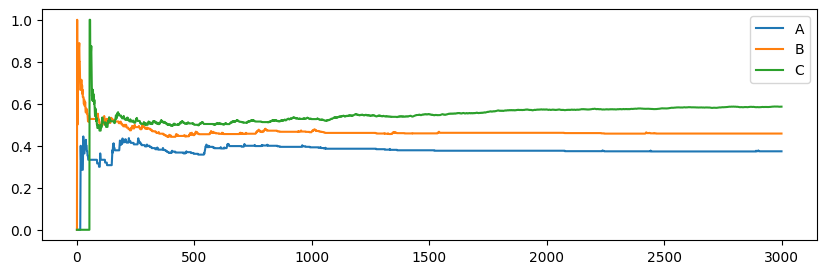

In [14]:
plt.rcParams["figure.figsize"] = (10,3)
plt.plot(list(range(n)), ctrs[0], label='A')
plt.plot(list(range(n)), ctrs[1], label='B')
plt.plot(list(range(n)), ctrs[2], label='C')
plt.legend()
plt.show()

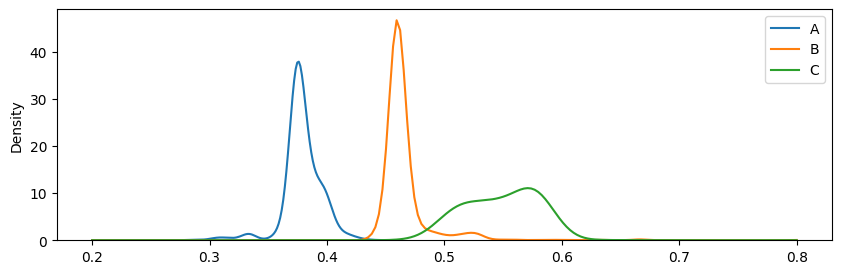

In [15]:
sns.kdeplot(ctrs[0], clip=(0.2, 0.8), label='A') 
sns.kdeplot(ctrs[1], clip=(0.2, 0.8), label='B')
sns.kdeplot(ctrs[2], clip=(0.2, 0.8), label='C')
plt.legend()

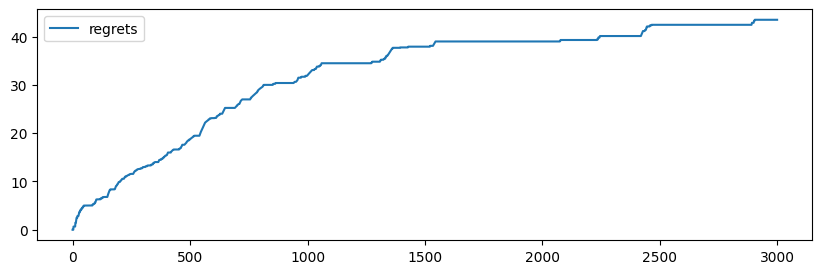

In [16]:
plot_regrets(ctrs, wins)

### Сэмплирование Томпсона

Сэмплирование Томпсона использует бета-распределение.<br>
Плотность бета-распределения $\Theta$:

$f_\Theta(x)=\frac{x^{\alpha - 1}(1 - x)^{\beta-1}}{B(\alpha, \beta)}$<br>
$B(\alpha, \beta)= \int\limits_0^1 x^{\alpha - 1}(1 - x)^{\beta - 1}dx; \alpha, \beta > 0$<br>

$E[\Theta]=\frac{\alpha}{\alpha + \beta}$<br>
$D[\Theta]=\frac{\alpha \beta}{(\alpha + \beta)^2(\alpha + \beta + 1)}$<br>


1. Задать распределения каждого автомата $R_i$ параметрами $\alpha_i$ и $\beta_i$.<br>
$\alpha_i = prior_i + reward_i$<br>
$\beta_i = prior_i + (1 - reward_i)$<br>
Для CTR:<br>
$\alpha_i = prior_i + clicks_i$<br>
$\beta_i = prior_i + (impressions_i - clicks_i)$

Если нет никакой предварительно известной информации, принять $prior_i=1$

In [17]:
alphas = [1] * k
betas = [1] * k
win_index = random.choice(list(range(k)))

2. Просэмплировать каждое распределение и найти автомат с максимальным вознаграждением, использовать этот автомат в текущем эксперименте.
3. Повторять 1-2 в течение заданного промежутка времени.

In [18]:
index_list = [] 
impressions = np.zeros(k)
clicks = np.zeros(k)
ctrs = {i: [] for i in range(k)}
wins = []

for t in range(n):
    wins.append(win_index)
    impressions[win_index] += 1
    did_click = click_bandit[win_index]()
    clicks[win_index] += did_click

    alphas[win_index] += did_click
    betas[win_index] += 1 - did_click
    step_ctrs = [np.random.beta(alphas[b], betas[b]) for b in range(k)]
    for b in range(k):
        ctrs[b].append(step_ctrs[b])

    win_index = np.argmax(step_ctrs)

for index in range(k):
    print(index, "interactions:\t", impressions[index])
    print(index, "interactions proportion:", impressions[index] / n)
    print(index, "CTR:\t", clicks[index] / impressions[index], "\n\n")
print("Total reward for", n, "impressions:", sum(clicks))
print("Optimal impressions rate:", get_optimal_impressions_rate(ctrs, wins))

0 interactions:	 13.0
0 interactions proportion: 0.004333333333333333
0 CTR:	 0.15384615384615385 

1 interactions:	 216.0
1 interactions proportion: 0.072
1 CTR:	 0.5324074074074074 

2 interactions:	 2771.0
2 interactions proportion: 0.9236666666666666
2 CTR:	 0.6167448574521833 

Total reward for 3000 impressions: 1826.0
Optimal impressions rate: 2674


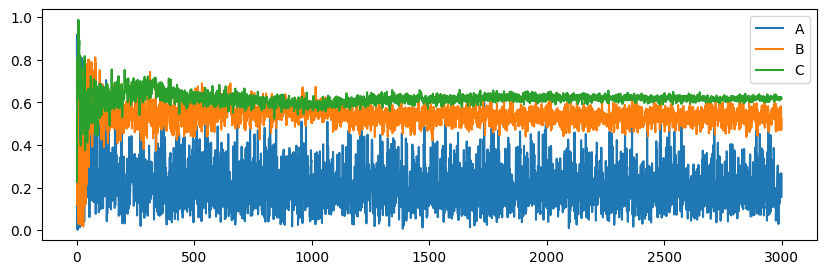

In [19]:
plt.rcParams["figure.figsize"] = (10,3)
plt.plot(list(range(n)), ctrs[0], label='A')
plt.plot(list(range(n)), ctrs[1], label='B')
plt.plot(list(range(n)), ctrs[2], label='C')
plt.legend()
plt.show()

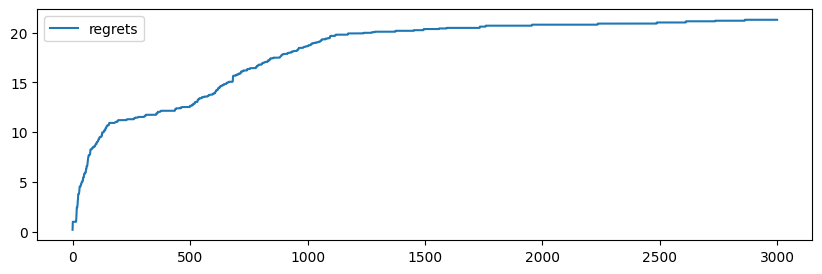

In [20]:
plot_regrets(ctrs, wins)

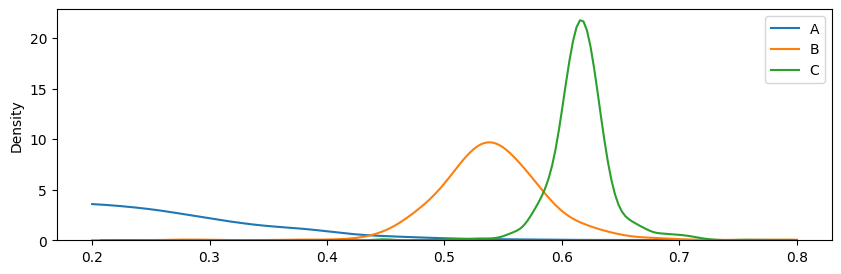

In [21]:
sns.kdeplot(ctrs[0], clip=(0.2, 0.8), label='A') 
sns.kdeplot(ctrs[1], clip=(0.2, 0.8), label='B')
sns.kdeplot(ctrs[2], clip=(0.2, 0.8), label='C')
plt.legend()